# PTEN trans effect

This notebook creates a boxplot for the trans effect of PTEN cnv deletions in 8 cancers. These 8 cancers were chosen because they have enough samples with PTEN cnv deletions to do a t-test. Only Ccrcc does not have enough samples with deletions. 

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import cptac
import cptac.utils as u
import plot_utils as p

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print('cptac version:', cptac.version())

cptac version: 0.8.6


Functions:

format_df prepares a data frame with PTEN proteomics and PTEN mutation type from get_genotype_all_vars.

format_pval_annotation is used to add marks to the boxplot. A star represents significant p-value and "ns" represents a nonsignificant p-value.

In [2]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


In [34]:
def mult_mutations(mut, list_in):
    if list_in.count(mut) > 1:
        name = 'Multiple_'+mut
    while mut in list_in: list_in.remove(mut)
    for e in list_in:
        name = e+', '+name
        
    name_list = name.split(', ') # return to list in case there are more multiple mutations
    
    return name
    

In [35]:
# NOTE: modified for cis graph. Makes mutation and compound mutation groups: (Truncation vs Truncation, other Mutation) 
#(Deletion vs Deletion, Somatic Mutations(s))

def find_multi_cis_mut(cancer_obj,cis_gene):
    #Get all somatic mutations 
    mutations = cancer_obj.get_somatic_mutation()
    #get just somatic mutations for cis_gene
    cis_mut = mutations[mutations.Gene == cis_gene]
    cis_mut = cis_mut[["Mutation"]]
    
    #simplfy names 
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'Missense_Mutation', 'Missense', inplace = True) # replaces when false
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'In_Frame_Del', 'Indel', inplace = True)
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'In_Frame_Ins', 'Indel', inplace = True)
    
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'nonframeshift insertion', 'Indel', inplace = True)
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'frameshift deletion', 'Truncation', inplace = True)
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'nonsynonymous SNV', 'Missense', inplace = True)
    
    #group Truncation
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'Nonsense_Mutation', 'Truncation', inplace = True)
    cis_mut["Mutation"].where(cis_mut['Mutation'] != 'Frame_Shift_Del', 'Truncation', inplace = True)
    cis_mut["Mutation"].where(cis_mut['Mutation'] != 'Frame_Shift_Ins', 'Truncation', inplace = True)
    
    
    # Multiple somatic mutations are indicated using multiple rows with the same patient ids.
    # We will group the rows by patient ids and then relabel the columns that have multiple mutations 
    
    cis_mut = cis_mut.groupby(level=['Patient_ID'], sort=False).agg( ','.join)
    cis_mut = cis_mut[['Mutation']].apply(lambda x: x.str.split(',')) # put in list to use mult_mutations function
    cis_mut.Mutation = cis_mut.Mutation.apply(lambda x: 'Truncation, Other_Mutation' if 'Truncation' in x and len(x) > 1 else x)
    # change list to string
    delim = ', '
    cis_mut.Mutation = cis_mut.Mutation.apply(lambda x: delim.join(x) if type(x) is list else x)

    #get CNV mutations 
    mut_copy_num = cancer_obj.get_genotype_all_vars(cis_gene, mutations_filter = ["Deletion","Amplification","Wildtype_Tumor"])
    mut_copy_num["Mutation"].where(mut_copy_num['Mutation'] != 'No_Mutation', 'Wildtype_Tumor', inplace = True) # change No_Mutation to Wildtype_Tumor
    mut_copy_num = mut_copy_num[mut_copy_num['Mutation'].isin(["Deletion","Amplification","Wildtype_Tumor"])]
    mut_copy_num = mut_copy_num.rename(columns={'Mutation': 'CNV_Mutation'})
    mut_copy_num = mut_copy_num["CNV_Mutation"]
    mutations = pd.merge(mut_copy_num, cis_mut, on="Patient_ID", how = "outer")
    
    # If mutation column is NaN replace with value in Mutation_Copy_Num
    mutations['Mutation'] = mutations.apply(
        lambda row: row['CNV_Mutation'] if pd.isnull(row['Mutation']) else row['Mutation'], axis=1)
    #mutations = mutations.CNV_Mutation.fillna('', inplace=True)
    #Make column All_Mutation which is a list of all mutations 
    mutations = mutations.replace(np.nan, '', regex=True)
    mutations['All_Mutations'] = mutations.apply(
        lambda row: row["CNV_Mutation"] + ", Other_Mutation" if (row["CNV_Mutation"] != row["Mutation"] and row["CNV_Mutation"] != "") else row['Mutation'], axis=1)
    mutations = mutations.rename(columns={'All_Mutations': 'All_Mutations_' + cis_gene})
    return mutations

In [37]:
find_multi_cis_mut(g, 'PTEN')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,CNV_Mutation,Mutation,All_Mutations_PTEN
Patient_ID,,,
C3L-00104,Deletion,Missense,"Deletion, Other_Mutation"
C3L-00365,Deletion,Deletion,Deletion
C3L-00674,Deletion,Missense,"Deletion, Other_Mutation"
C3L-00677,Deletion,Missense,"Deletion, Other_Mutation"
C3L-01040,Deletion,Deletion,Deletion
...,...,...,...
C3N-03186,Deletion,Deletion,Deletion
C3N-03188,Wildtype_Tumor,Wildtype_Tumor,Wildtype_Tumor
C3N-03473,Deletion,Deletion,Deletion


# Step 1: Create data frames with PTEN cnv deletion and Proteomics

Each cancer needs a data frame containing only samples that have PTEN cnv deletions or PTEN wildtype tumors and PTEN proteomics.

First, load in cancer data sets from cptac.

In [5]:
en = cptac.Endometrial()
h = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
col = cptac.Colon()
g = cptac.Gbm()
b = cptac.Brca()

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 2)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)


cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 7)


Next, use format_df to create the specific data frame for each cancer. Use wrap_ttest to test PTEN deletion vs. wildtype. 

# Get PTEN deletion

In [55]:
#Select the cancers that you would like to test and add cptac data into a dictionary
cptac_cancers = {'GBM':g, 'HNSCC':h, 'LUAD':l, 'LSCC':ls, 'BR':b, 'CO':col, 'OV':o}
cis_gene1 = "PTEN"
gene1_mut = ["Deletion", "Deletion, Other_Mutation", "Wildtype_Tumor"]
trans_gene = 'MSH2' # 'MSH6' #'CHUK'
#trans_gene = 'PRKDC'

mut_dfs = {}
for cancer in cptac_cancers:

    gene1_mutations = find_multi_cis_mut(cptac_cancers[cancer],cis_gene1)
    gene1_mutations = gene1_mutations[["All_Mutations_"+cis_gene1]]
    
    #gene1_mutations['All_Mutations_' + cis_gene1] = [','.join(map(str, l)) for l in gene1_mutations['All_Mutations_' + cis_gene1]]
    gene1_mutations["Cancer"] = cancer
    
    #only gene1 with specified mutation
    gene1_mutated = gene1_mutations.loc[gene1_mutations['All_Mutations_'+cis_gene1].isin(gene1_mut)]
    
    mut_dfs[cancer] = gene1_mutated
    # Create csv
    #gene1_mut_gene2_wt.to_csv('csv/'+cancer+'_pten_mut_pik3ca_wt.csv', index=False)
    print(cancer, gene1_mutated[["All_Mutations_"+cis_gene1]].value_counts(), '\n')
    

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
cptac warning: In joining the somatic_mutation table, no muta

GBM All_Mutations_PTEN      
Deletion                    56
Deletion, Other_Mutation    25
Wildtype_Tumor              16
dtype: int64 

HNSCC All_Mutations_PTEN      
Wildtype_Tumor              89
Deletion                    17
Deletion, Other_Mutation     1
dtype: int64 

LUAD All_Mutations_PTEN
Wildtype_Tumor        88
Deletion              17
dtype: int64 

LSCC All_Mutations_PTEN      
Wildtype_Tumor              58
Deletion                    35
Deletion, Other_Mutation     4
dtype: int64 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 96 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 113 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)


BR All_Mutations_PTEN      
Wildtype_Tumor              80
Deletion                    21
Deletion, Other_Mutation     3
dtype: int64 

CO All_Mutations_PTEN      
Wildtype_Tumor              76
Deletion                    23
Deletion, Other_Mutation     2
dtype: int64 

OV All_Mutations_PTEN      
Wildtype_Tumor              57
Deletion                    24
Deletion, Other_Mutation     2
dtype: int64 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 100 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 98 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 01OV029, 02OV015 (C:\Users\brittany henderson\Anaconda3\

In [56]:
gene = 'PTEN'
plot_dfs = {}

for cancer in cptac_cancers:
    ca = cptac_cancers[cancer]
    
    # get proteomics
    prot = ca.get_proteomics(tissue_type = 'tumor') 
    if isinstance(prot.keys(), pd.core.indexes.multi.MultiIndex):
        prot = u.reduce_multiindex(prot, levels_to_drop = 1)
    prot = prot[[trans_gene]]

    # get proteomics and only pten deletion
    mut_df = mut_dfs[cancer]
    pten_mut = mut_df[['All_Mutations_'+gene]]
    only_del = prot.join(pten_mut, how = 'outer')
    pten_del = only_del.dropna(subset = ['All_Mutations_'+gene]) # keep only pten deletions (no pik3ca mut)
    pten_del['cancer'] = cancer

    plot_dfs[cancer] = pten_del
    
    print(cancer, pten_del[["All_Mutations_"+gene]].value_counts(), '\n')
    
    binary_df = pten_del.loc[pten_del['All_Mutations_'+gene] != 'Deletion, Other_Mutation']
    print(binary_df['All_Mutations_'+gene].unique())
    pval = u.wrap_ttest(binary_df, 'All_Mutations_'+gene, [trans_gene], mincount = 3, return_all = True)
    print(pval, '\n')
    

GBM All_Mutations_PTEN      
Deletion                    56
Deletion, Other_Mutation    25
Wildtype_Tumor              16
dtype: int64 

['Deletion' 'Wildtype_Tumor']
  Comparison   P_Value
0       MSH2  0.002346 

HNSCC All_Mutations_PTEN      
Wildtype_Tumor              89
Deletion                    17
Deletion, Other_Mutation     1
dtype: int64 

['Wildtype_Tumor' 'Deletion']
  Comparison   P_Value
0       MSH2  0.001178 

LUAD All_Mutations_PTEN
Wildtype_Tumor        88
Deletion              17
dtype: int64 

['Deletion' 'Wildtype_Tumor']
  Comparison   P_Value
0       MSH2  0.098071 

LSCC All_Mutations_PTEN      
Wildtype_Tumor              58
Deletion                    35
Deletion, Other_Mutation     4
dtype: int64 

['Deletion' 'Wildtype_Tumor']
  Comparison   P_Value
0       MSH2  0.000129 

BR All_Mutations_PTEN      
Wildtype_Tumor              80
Deletion                    21
Deletion, Other_Mutation     3
dtype: int64 

['Wildtype_Tumor' 'Deletion']
  Comparison   P_Va

C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 10)
C:\Users\brittany henderson

 

CO All_Mutations_PTEN      
Wildtype_Tumor              76
Deletion                    23
Deletion, Other_Mutation     2
dtype: int64 

['Wildtype_Tumor' 'Deletion']
  Comparison   P_Value
0       MSH2  0.829297 

OV All_Mutations_PTEN      
Wildtype_Tumor              57
Deletion                    24
Deletion, Other_Mutation     2
dtype: int64 

['Deletion' 'Wildtype_Tumor']
  Comparison   P_Value
0       MSH2  0.540656 




C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Endometrial

The Endometrial data set does not have enough cnv deletions to perform a t-test, however the data set does have enough truncation type mutations (nonsense and frame shifts). Different code is needed to create the data frame for Endometrial.

In [57]:
#Select the cancers that you would like to test and add cptac data into a dictionary
endo = {'EC':en}
cis_gene1 = "PTEN"
gene1_mut = ["Truncation", 'Truncation, Other_Mutation', "Wildtype_Tumor"]

endo_df = {}
for cancer in endo:

    gene1_mutations = find_multi_cis_mut(endo[cancer],cis_gene1)
    gene1_mutations = gene1_mutations[["All_Mutations_"+cis_gene1]]

    #gene1_mutations['All_Mutations_' + cis_gene1] = [','.join(map(str, l)) for l in gene1_mutations['All_Mutations_' + cis_gene1]]
    gene1_mutations["Cancer"] = cancer
    
    #only gene1 with specified mutation
    gene1_mutated = gene1_mutations.loc[gene1_mutations['All_Mutations_'+cis_gene1].isin(gene1_mut)]

    endo_df[cancer] = gene1_mutated
    # Create csv
    #gene1_mut_gene2_wt.to_csv('csv/'+cancer+'_pten_mut_pik3ca_wt.csv', index=False)
    print(cancer, gene1_mutated[["All_Mutations_"+cis_gene1]].value_counts(), '\n')
    

EC All_Mutations_PTEN        
Truncation, Other_Mutation    25
Truncation                    17
Wildtype_Tumor                15
dtype: int64 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [58]:
gene = 'PTEN'

for cancer in endo:
    ca = endo[cancer]
    
    # get proteomics
    prot = ca.get_proteomics(tissue_type = 'tumor') 
    prot = prot[[trans_gene]]

    # get proteomics and only pten deletion
    mut_df = endo_df[cancer]
    pten_mut = mut_df[['All_Mutations_'+gene]]

    # join
    only_del = prot.join(pten_mut, how = 'outer')
    pten_del = only_del.dropna(subset = ['All_Mutations_'+gene]) # keep only pten deletions (no pik3ca mut)
    
    # add to pancancer dictionary
    pten_del['cancer'] = cancer
    plot_dfs[cancer] = pten_del    
    print(cancer, pten_del[["All_Mutations_"+gene]].value_counts(), '\n')
    
    binary_df = pten_del.loc[pten_del['All_Mutations_'+gene] != 'Truncation, Other_Mutation']
    print(binary_df['All_Mutations_'+gene].unique())
    pval = u.wrap_ttest(binary_df, 'All_Mutations_'+gene, [trans_gene], mincount = 3, return_all = True)
    print(pval, '\n')
    

EC All_Mutations_PTEN        
Truncation, Other_Mutation    25
Truncation                    17
Wildtype_Tumor                15
dtype: int64 

['Truncation' 'Wildtype_Tumor']
  Comparison   P_Value
0       MSH2  0.002041 



C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Step 2: Create a long dataframe for the boxplot

The boxplot will take three columns: Proteomics, Mutation, and Cancer. We need to append all the individual cancer dfs into one long pancancer df. 

Next append the dfs.

In [59]:
all_df = pd.DataFrame()
for cancer in plot_dfs:
    df = plot_dfs[cancer]
    print(cancer, len(df))
    all_df = all_df.append(df) 

GBM 97
HNSCC 107
LUAD 105
LSCC 97
BR 104
CO 101
OV 83
EC 57


In [60]:
all_df = all_df.loc[all_df['cancer'] != 'HNSCC'] #take out hnscc (different scale)

# Step 3: Create the Pancancer Boxplot

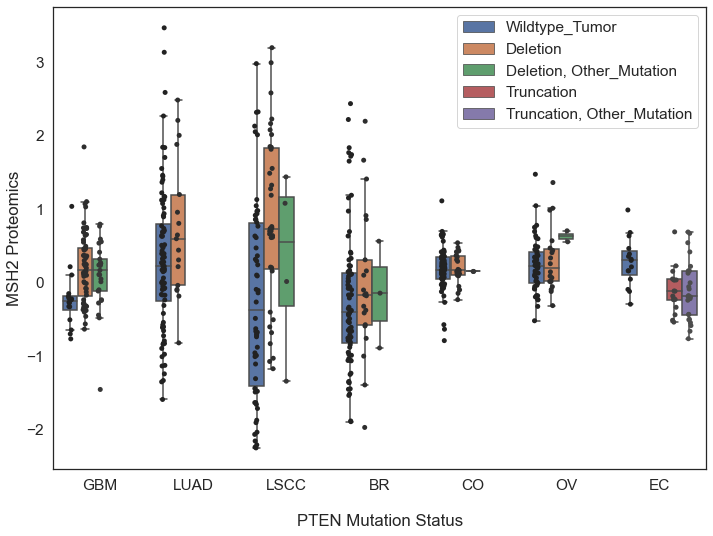

In [66]:
# cis plot
gene = 'PTEN'
plt.rcParams['figure.figsize']=(11.7, 8.5) #size of plot
sns.set(font_scale = 1.4, style = 'white')

boxplot = sns.boxplot(data = all_df, x='cancer', y=trans_gene, hue = 'All_Mutations_'+gene,
                      hue_order = ["Wildtype_Tumor", "Deletion", 'Deletion, Other_Mutation', 'Truncation',
                                  'Truncation, Other_Mutation'], showfliers = False)    
#boxplot.set_title('Pancancer cis effect of PTEN CNV Deletions')
boxplot = sns.stripplot(data = all_df, x='cancer', y=trans_gene, jitter = True, 
                           color = ".3", hue = 'All_Mutations_'+gene, hue_order = ["Wildtype_Tumor", "Deletion", 
                            'Deletion, Other_Mutation', 'Truncation', 'Truncation, Other_Mutation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Mutation Status", ylabel = trans_gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:5], labels[0:5])

In [67]:
# Save figure
fig = boxplot.get_figure()
fig.savefig("MSH2_trans_boxplot.png", dpi = 300)

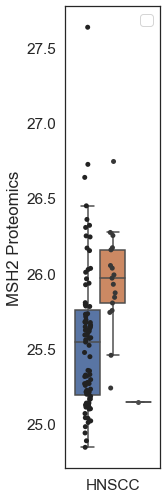

In [71]:
# Figure for Hnscc (higher scale)
gene = 'PTEN'
df = plot_dfs['HNSCC']
plt.rcParams['figure.figsize']=(1.7,8.5) #size of plot
sns.set(font_scale = 1.4, style = 'white')

boxplot = sns.boxplot(x='cancer', y=trans_gene, data = df, hue = 'All_Mutations_'+gene,
                      hue_order = ["Wildtype_Tumor", "Deletion", 'Deletion, Other_Mutation'], showfliers = False)    
boxplot = sns.stripplot(x='cancer', y=trans_gene, data = df, jitter = True, 
                           color = ".3", dodge = True, hue = 'All_Mutations_'+gene, hue_order = ["Wildtype_Tumor",
                        "Deletion", 'Deletion, Other_Mutation'],)
boxplot.set(xlabel = "", ylabel = trans_gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:0], labels[0:0])

#format_pval_annotation(symbols['HNSCC'], -.2, .2, 24.8) '''

plt.show()
plt.clf()
plt.close()

In [72]:
# Save figure
fig = boxplot.get_figure()
fig.savefig("MSH2_HNSCC.png", bbox_inches="tight", dpi = 300)